
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Gradient Attribution


In [ ]:
#@title Import libraries
import transformer_lens
import torch, gc, itertools, functools
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import modelHandlers, dataLoaders, gradient, localizing

## Model

In [ ]:
model = modelHandlers.load_model(model_type="gpt-neo-125M", DEVICE="cpu", lr=0.0)

## Load Data

In [ ]:
## mem and non-mem set
#(mem_prompts, mem_counts),(non_mem_prompts,non_mem_counts) = dataLoaders.load_pile_splits("acc/gpt-neo-125M", as_torch=True)
#train_dl, test_dl = dataLoaders.train_test_batching(mem_prompts, non_mem_prompts, mem_batch=5, non_mem_batch=5, test_frac=0.0, set_twice=None)
#c_toks_NI, k_toks_NI = next(iter(train_dl))

## load perturbed mem set and original mem set
mem_prompts, non_mem_prompts = dataLoaders.load_perturbed_mem(file_path="acc/gpt-neo-125M")
train_dl = torch.utils.data.DataLoader(list(zip(mem_prompts, non_mem_prompts)), batch_size=10, shuffle=False)
c_toks_NI, k_toks_NI = next(iter(train_dl))

#c_toks_NI, k_toks_NI = c_toks_NI[0,:], k_toks_NI[0,:]

## Gradient Attribution

In [ ]:
metric_fn = functools.partial(gradient.contrast_metric, I_range=[50,100], pool={"c":[-1],"k":[0,-1]}, norm_sets=5.0)
fwd_bwd_fn = functools.partial(gradient.run_fwd_bwd, optim_step=False, grad_norm=None)
c_type_gradsum = gradient.batched_fwd_bwd(model, train_dl, metric_fn, fwd_bwd_fn, n_batches=1, c_types=["W_Q","W_K","W_V","W_O","W_in","W_out"])

In [ ]:
metric_fn = functools.partial(gradient.contrast_metric, I_range=[50,100], pool={"c":[-1],"k":[0,-1]}, norm_sets=None, only_set="c")
cbase_gradsum = gradient.batched_fwd_bwd(model, train_dl, metric_fn, fwd_bwd_fn, n_batches=1, c_types=["W_Q","W_K","W_V","W_O","W_in","W_out"])

metric_fn = functools.partial(gradient.contrast_metric, I_range=[50,100], pool={"c":[-1],"k":[0,-1]}, norm_sets=None, only_set="k")
kbase_gradsum = gradient.batched_fwd_bwd(model, train_dl, metric_fn, fwd_bwd_fn, n_batches=1, c_types=["W_Q","W_K","W_V","W_O","W_in","W_out"])

Text(145.72222222222223, 0.5, 'layer')

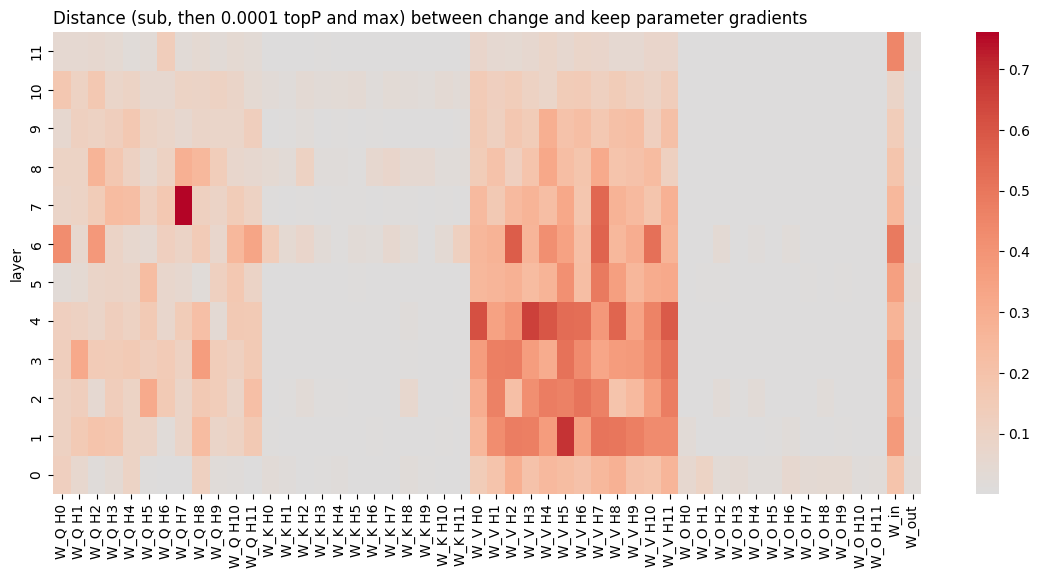

In [51]:
dist, pool, topP = "sub", "max", 0.0001
dist_vals, x, y = localizing.pool_c_weights(cbase_gradsum, kbase_gradsum, topP=topP, dist=dist, pool=pool, keep_heads=True)

fontsize = 12
fig, ax = plt.subplots(1, 1, figsize=(14, 6), gridspec_kw={'hspace': 0.4})
ax = sns.heatmap(dist_vals.numpy(),cmap=mpl.colormaps["coolwarm"],center=0,xticklabels=x,yticklabels=y,square=False)
ax.invert_yaxis()

ax.set_title(f"Distance ({dist}, then {topP} topP and {pool}) between change and keep parameter gradients", fontsize=fontsize, loc="left")
ax.set_ylabel("layer")

## Parameter Gradients

In [52]:
pool, norm_by_weights, topP = "mean", False, 0.0001#(1/(64*768))
vals, x, y = localizing.pool_c_weights(c_type_gradsum, pool=pool,topP=topP,norm_by_weights=norm_by_weights, keep_heads=True)
cvals, x, y = localizing.pool_c_weights(cbase_gradsum,pool=pool,topP=topP,norm_by_weights=norm_by_weights, keep_heads=True)
kvals, x, y = localizing.pool_c_weights(kbase_gradsum,pool=pool,topP=topP,norm_by_weights=norm_by_weights, keep_heads=True)
cvals = ((kvals.sum()/cvals.sum()) * cvals)

In [53]:
ckvals = (cvals - kvals)# / (kvals)
#ckvals = (kvals / cvals) 

Text(145.72222222222223, 0.5, 'layer')

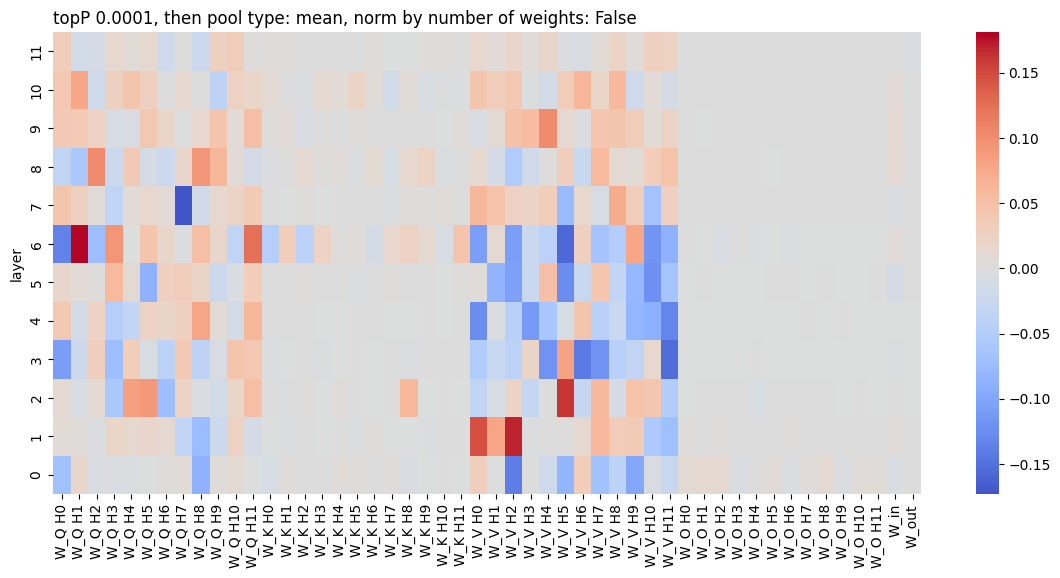

In [54]:
fontsize = 12
fig, ax = plt.subplots(1, 1, figsize=(14, 6), gridspec_kw={'hspace': 0.4})
ax = sns.heatmap(ckvals.numpy(),cmap=mpl.colormaps["coolwarm"],center=0,xticklabels=x,yticklabels=y,square=False)
ax.invert_yaxis()

ax.set_title(f"topP {topP}, then pool type: {pool}, norm by number of weights: {norm_by_weights}", fontsize=fontsize, loc="left")
ax.set_ylabel("layer")

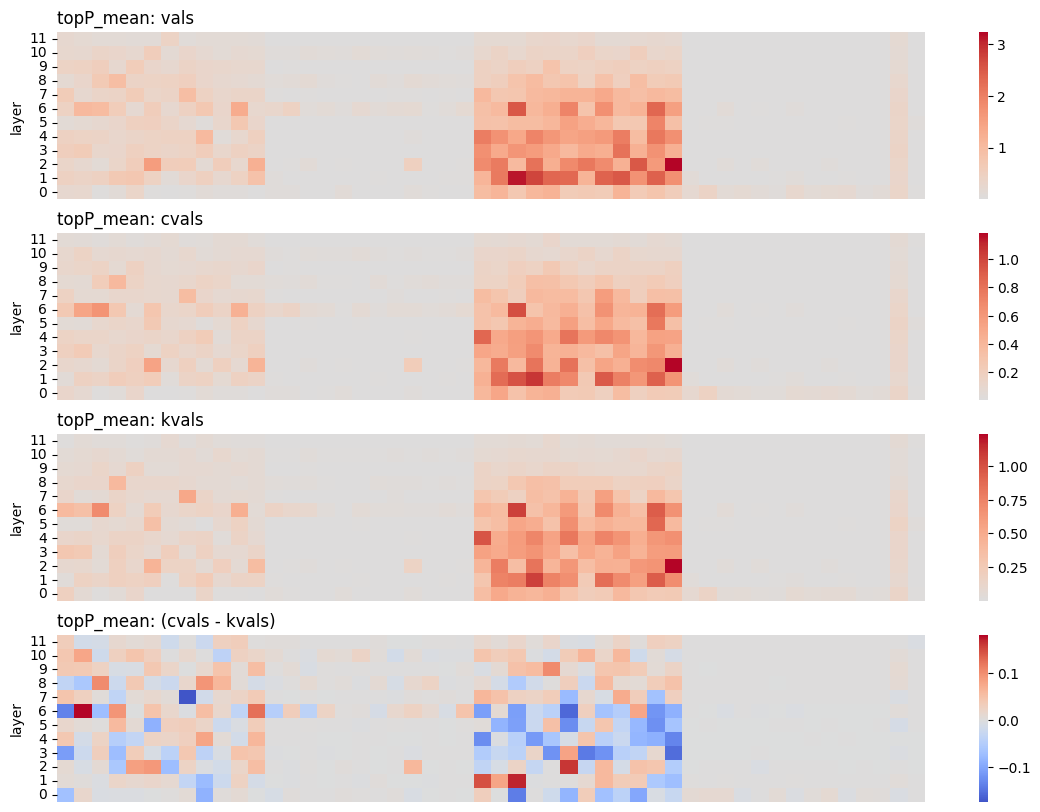

In [55]:
fontsize = 12
fig, axs = plt.subplots(4, 1, figsize=(14, 10), gridspec_kw={'wspace': 0.05})

pool_type = "topP_mean"
title = ["vals", "cvals", "kvals", "(cvals - kvals)"]
for i, v in enumerate([vals, cvals, kvals, (cvals - kvals)]):
    
    ax.set_title(f"topP {topP}, then pool type: {pool}, norm by number of weights: {norm_by_weights}", fontsize=fontsize, loc="left")
    sns.heatmap(v.numpy(),cmap=mpl.colormaps["coolwarm"],ax=axs[i],center=0,xticklabels=x,yticklabels=y,square=False)
    axs[i].invert_yaxis()
    if i < 4:
        axs[i].get_xaxis().set_ticks([])

    axs[i].set_title(f"{pool_type}: {title[i]}", fontsize=fontsize, loc="left")
    axs[i].set_ylabel("layer")
    
#fig.savefig(f"{pool_type}.png", dpi=200, bbox_inches='tight')

#### 